In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder


In [16]:

# Load Titanic dataset 
data = sns.load_dataset('titanic')

# Inspect data
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [17]:

# Handle missing values
data['age'].fillna(data['age'].median(), inplace=True)
data['embarked'].fillna(data['embarked'].mode()[0], inplace=True)

# For the 'deck' column, first add 'Unknown' as a category if it does not exist
if 'Unknown' not in data['deck'].cat.categories:
    data['deck'] = data['deck'].cat.add_categories('Unknown')

# Now fill the missing values with 'Unknown'
data['deck'].fillna('Unknown', inplace=True)

# Drop unnecessary columns
data.drop(['who', 'adult_male', 'alive', 'class', 'embark_town'], axis=1, inplace=True)

# Encode categorical variables
le = LabelEncoder()
for col in ['sex', 'embarked', 'deck', 'alone']:
    data[col] = le.fit_transform(data[col])

# Feature Engineering: Family Size
data['family_size'] = data['sibsp'] + data['parch'] + 1

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       105
           1       0.82      0.73      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



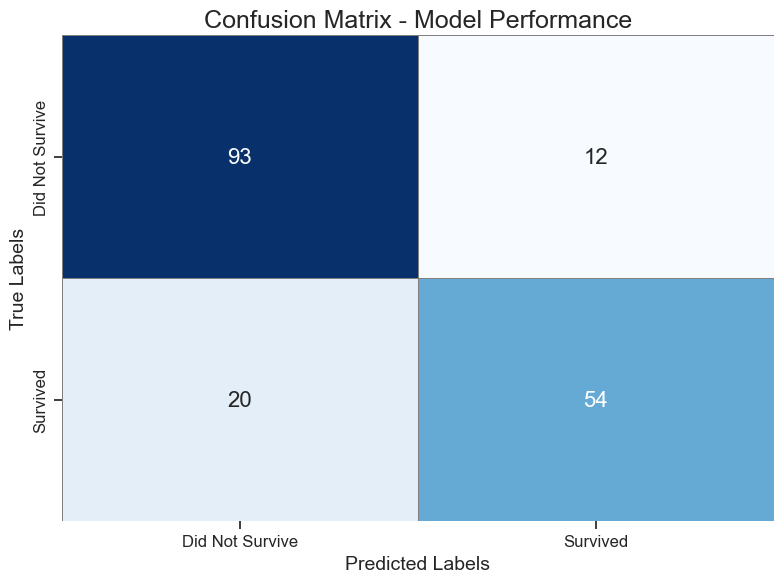

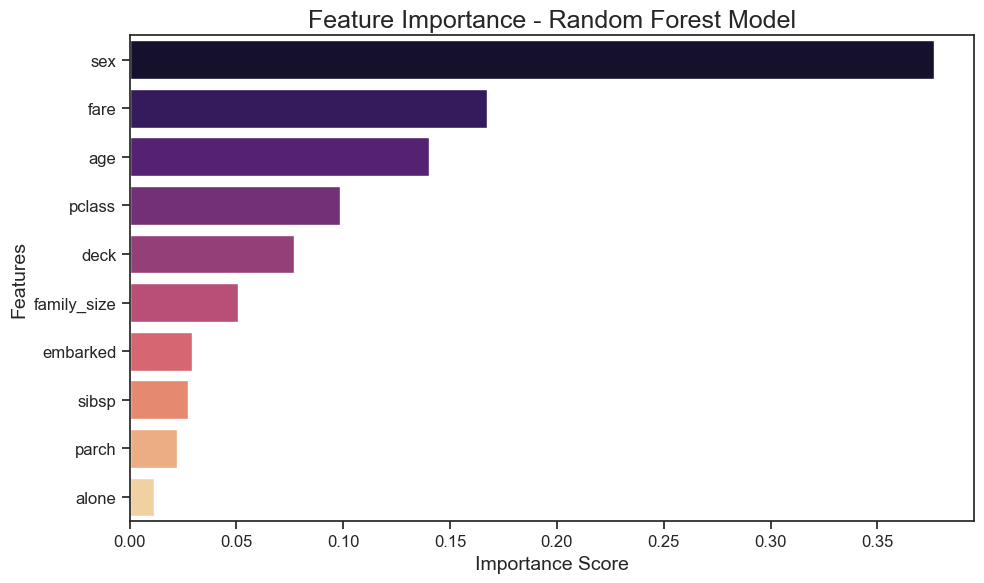

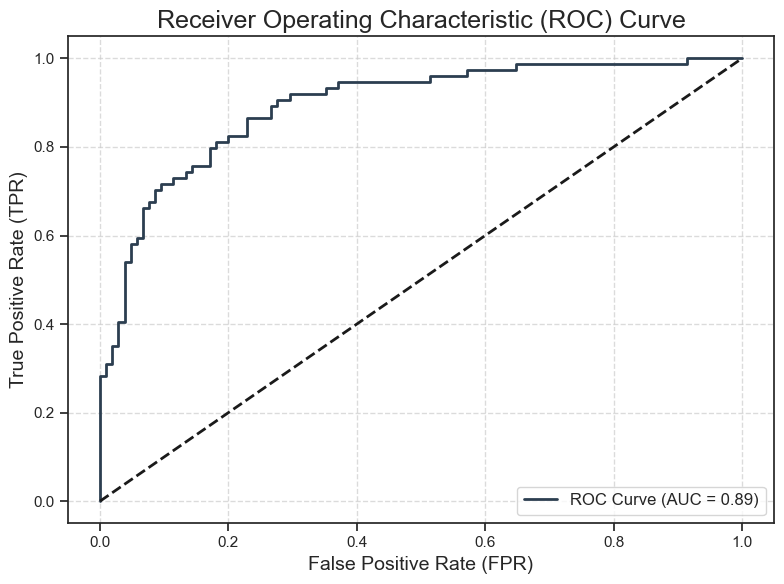

In [18]:

# Select features and target
X = data.drop(['survived'], axis=1)
y = data['survived']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Grid Search for best parameters
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_

# Evaluate model
y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Set the style to a professional theme
sns.set(style="ticks", palette="muted")
plt.figure(figsize=(8, 6))

# Plot confusion matrix with a professional color scheme
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Did Not Survive', 'Survived'], 
            yticklabels=['Did Not Survive', 'Survived'], cbar=False, linewidths=0.5, linecolor='gray', annot_kws={"size": 16})
plt.title('Confusion Matrix - Model Performance', fontsize=18)
plt.ylabel('True Labels', fontsize=14)
plt.xlabel('Predicted Labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Feature Importance
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': best_rf.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot feature importances with a refined color palette
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette="magma")
plt.title('Feature Importance - Random Forest Model', fontsize=18)
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# ROC Curve
y_pred_prob = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve with a professional, muted color scheme
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='#2c3e50', lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=18)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
